# Determine Enhancer-Enhancer Pairs

This notebook is used to determine the enhancer pairs present in the Gasperini at-scale screen, by first determining all enhancers within 1 MB of a gene, and then generating all pairwise enhancer combinations.

Author: Karthik Guruvayurappan

In [56]:
import pandas as pd
import numpy as np
import itertools

In [2]:
enhancer_gene_pairs = pd.read_csv('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_gene_gRNAgroup_pair_table.at_scale.txt', sep = '\t')

/iblm/netapp/home/karthik/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
enhancer_gene_pairs.head()

,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup,general_group,chr.targetgene,start.targetgene,stop.targetgene,ENSG.targetgene,targetgene_short_name,strand.targetgene,pairs
0,NTC,NTC,NTC,bassik_mch,NTC,chr10,28034777,28034778,ENSG00000150051,MKX,-,MKX:bassik_mch
1,NTC,NTC,NTC,bassik_mch,NTC,chr10,28287976,28287977,ENSG00000169126,ARMC4,-,ARMC4:bassik_mch
2,NTC,NTC,NTC,bassik_mch,NTC,chr10,28571017,28571018,ENSG00000150054,MPP7,-,MPP7:bassik_mch
3,NTC,NTC,NTC,bassik_mch,NTC,chr10,28821422,28821423,ENSG00000095787,WAC,+,WAC:bassik_mch
4,NTC,NTC,NTC,bassik_mch,NTC,chr10,28966271,28966272,ENSG00000095739,BAMBI,+,BAMBI:bassik_mch


In [4]:
enhancer_gene_pairs.shape

(1086564, 12)

In [24]:
# get unique enhancers from enhancer-gene pairs
enhancers = enhancer_gene_pairs[['gRNAgroup', 'gRNAgroup.chr', 'gRNAgroup.start', 'gRNAgroup.stop', 'general_group']]
enhancers = enhancers.drop_duplicates()
enhancers = enhancers[enhancers['general_group'] != 'NTC']
enhancers = enhancers[enhancers['general_group'] != 'positive_ctrl']
enhancers = enhancers[enhancers['general_group'] != 'TSS']
enhancers = enhancers.reset_index(drop=True)
enhancers.head()

,gRNAgroup,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,general_group
0,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested
1,chr10.1018_top_two,chr10,29111303,29112331,test_5k-untested
2,chr10.1019_top_two,chr10,29115307,29115488,test_5k-untested
3,chr10.1020_top_two,chr10,29128454,29128983,test_5k-untested
4,chr10.1030_top_two,chr10,29275275,29275635,test_5k-untested


In [25]:
enhancers.shape

(6144, 5)

In [35]:
# get unique genes
genes = enhancer_gene_pairs[['ENSG.targetgene', 'chr.targetgene', 'start.targetgene', 'stop.targetgene']]
genes = genes.drop_duplicates()
genes['position.targetgene'] = (genes['start.targetgene'] + genes['stop.targetgene']) / 2
genes.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene
0,ENSG00000150051,chr10,28034777,28034778,28034777.5
1,ENSG00000169126,chr10,28287976,28287977,28287976.5
2,ENSG00000150054,chr10,28571017,28571018,28571017.5
3,ENSG00000095787,chr10,28821422,28821423,28821422.5
4,ENSG00000095739,chr10,28966271,28966272,28966271.5


In [40]:
# find all enhancers within 1MB of each gene 
def find_proximal_enhancers(gene):
    '''finds enhancers within 1MB of gene'''

    gene_chrom = gene['chr.targetgene']
    gene_position = gene['position.targetgene']

    match_chrom = gene_chrom == enhancers['gRNAgroup.chr']
    match_position = np.abs(gene_position - enhancers['gRNAgroup.position']) < 1000000

    match_enhancers = np.array(enhancers[match_chrom & match_position]['gRNAgroup'])
    return match_enhancers

genes['proximal_enhancers'] = genes.apply(find_proximal_enhancers, axis = 1)
genes.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene,proximal_enhancers
0,ENSG00000150051,chr10,28034777,28034778,28034777.5,"[chr10.1007_top_two, chr10.995_top_two]"
1,ENSG00000169126,chr10,28287976,28287977,28287976.5,"[chr10.1007_top_two, chr10.1018_top_two, chr10..."
2,ENSG00000150054,chr10,28571017,28571018,28571017.5,"[chr10.1007_top_two, chr10.1018_top_two, chr10..."
3,ENSG00000095787,chr10,28821422,28821423,28821422.5,"[chr10.1007_top_two, chr10.1018_top_two, chr10..."
4,ENSG00000095739,chr10,28966271,28966272,28966271.5,"[chr10.1007_top_two, chr10.1018_top_two, chr10..."


In [53]:
genes.shape

(18389, 6)

In [42]:
enhancer_gene = genes.explode('proximal_enhancers', ignore_index = True)
enhancer_gene.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene,proximal_enhancers
0,ENSG00000150051,chr10,28034777,28034778,28034777.5,chr10.1007_top_two
1,ENSG00000150051,chr10,28034777,28034778,28034777.5,chr10.995_top_two
2,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1007_top_two
3,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1018_top_two
4,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1019_top_two


In [43]:
enhancer_gene = enhancer_gene.merge(enhancers, left_on = 'proximal_enhancers', right_on = 'gRNAgroup')
enhancer_gene.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene,proximal_enhancers,gRNAgroup,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,general_group,gRNAgroup.position
0,ENSG00000150051,chr10,28034777,28034778,28034777.5,chr10.1007_top_two,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested,29024189.0
1,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1007_top_two,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested,29024189.0
2,ENSG00000150054,chr10,28571017,28571018,28571017.5,chr10.1007_top_two,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested,29024189.0
3,ENSG00000095787,chr10,28821422,28821423,28821422.5,chr10.1007_top_two,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested,29024189.0
4,ENSG00000095739,chr10,28966271,28966272,28966271.5,chr10.1007_top_two,chr10.1007_top_two,chr10,29023920,29024458,test_5k-untested,29024189.0


In [44]:
enhancer_gene = enhancer_gene.drop(['proximal_enhancers', 'general_group'], axis = 1)
enhancer_gene.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene,gRNAgroup,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup.position
0,ENSG00000150051,chr10,28034777,28034778,28034777.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0
1,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0
2,ENSG00000150054,chr10,28571017,28571018,28571017.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0
3,ENSG00000095787,chr10,28821422,28821423,28821422.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0
4,ENSG00000095739,chr10,28966271,28966272,28966271.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0


In [45]:
enhancer_gene['enhancer_gene_distance'] = np.abs(enhancer_gene['position.targetgene'] - enhancer_gene['gRNAgroup.position'])
enhancer_gene.head()

,ENSG.targetgene,chr.targetgene,start.targetgene,stop.targetgene,position.targetgene,gRNAgroup,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup.position,enhancer_gene_distance
0,ENSG00000150051,chr10,28034777,28034778,28034777.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0,989411.5
1,ENSG00000169126,chr10,28287976,28287977,28287976.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0,736212.5
2,ENSG00000150054,chr10,28571017,28571018,28571017.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0,453171.5
3,ENSG00000095787,chr10,28821422,28821423,28821422.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0,202766.5
4,ENSG00000095739,chr10,28966271,28966272,28966271.5,chr10.1007_top_two,chr10,29023920,29024458,29024189.0,57917.5


In [46]:
enhancer_gene.shape

(140941, 11)

<AxesSubplot:>

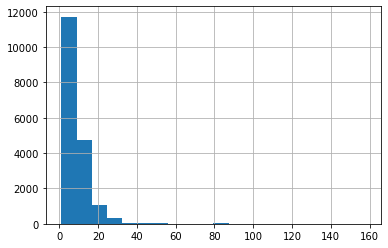

In [52]:
enhancer_gene.groupby('ENSG.targetgene').count()['chr.targetgene'].hist(bins = 20)

In [55]:
enhancer_gene = enhancer_gene[['ENSG.targetgene', 'gRNAgroup']]
enhancer_gene.head()

,ENSG.targetgene,gRNAgroup
0,ENSG00000150051,chr10.1007_top_two
1,ENSG00000169126,chr10.1007_top_two
2,ENSG00000150054,chr10.1007_top_two
3,ENSG00000095787,chr10.1007_top_two
4,ENSG00000095739,chr10.1007_top_two


In [65]:
def get_pairwise_enhancers(gene_enhancers):
    return list(itertools.combinations(gene_enhancers['gRNAgroup'], 2))

enhancer_enhancer_gene = pd.DataFrame(enhancer_gene.groupby('ENSG.targetgene').apply(get_pairwise_enhancers))
enhancer_enhancer_gene.head()

,0
ENSG.targetgene,
ENSG00000000003,[]
ENSG00000000005,[]
ENSG00000000419,"[(chr20.2275_top_two, chr20.2276_top_two), (ch..."
ENSG00000000457,[]
ENSG00000000460,[]


In [66]:
enhancer_enhancer_gene = enhancer_enhancer_gene.reset_index()
enhancer_enhancer_gene.head()

,ENSG.targetgene,0
0,ENSG00000000003,[]
1,ENSG00000000005,[]
2,ENSG00000000419,"[(chr20.2275_top_two, chr20.2276_top_two), (ch..."
3,ENSG00000000457,[]
4,ENSG00000000460,[]


In [68]:
enhancer_enhancer_gene.columns = ['gene', 'enhancer_pair']
enhancer_enhancer_gene.head()

,gene,enhancer_pair
0,ENSG00000000003,[]
1,ENSG00000000005,[]
2,ENSG00000000419,"[(chr20.2275_top_two, chr20.2276_top_two), (ch..."
3,ENSG00000000457,[]
4,ENSG00000000460,[]


In [69]:
enhancer_enhancer_gene = enhancer_enhancer_gene.explode('enhancer_pair', ignore_index = True)
enhancer_enhancer_gene.head()

,gene,enhancer_pair
0,ENSG00000000003,NaN
1,ENSG00000000005,NaN
2,ENSG00000000419,"(chr20.2275_top_two, chr20.2276_top_two)"
3,ENSG00000000419,"(chr20.2275_top_two, chr20.2279_top_two)"
4,ENSG00000000419,"(chr20.2275_top_two, chr20.2320_top_two)"


In [71]:
enhancer_enhancer_gene = enhancer_enhancer_gene.dropna()
enhancer_enhancer_gene.head()

,gene,enhancer_pair
2,ENSG00000000419,"(chr20.2275_top_two, chr20.2276_top_two)"
3,ENSG00000000419,"(chr20.2275_top_two, chr20.2279_top_two)"
4,ENSG00000000419,"(chr20.2275_top_two, chr20.2320_top_two)"
5,ENSG00000000419,"(chr20.2275_top_two, chr20.2321_top_two)"
6,ENSG00000000419,"(chr20.2275_top_two, chr20.2355_top_two)"


In [72]:
enhancer_enhancer_gene.shape

(976243, 2)

In [74]:
enhancer_enhancer_gene['enhancer_1'] = enhancer_enhancer_gene['enhancer_pair'].apply(lambda x: x[0])
enhancer_enhancer_gene['enhancer_2'] = enhancer_enhancer_gene['enhancer_pair'].apply(lambda x: x[1])
enhancer_enhancer_gene.head()

,gene,enhancer_pair,enhancer_1,enhancer_2
2,ENSG00000000419,"(chr20.2275_top_two, chr20.2276_top_two)",chr20.2275_top_two,chr20.2276_top_two
3,ENSG00000000419,"(chr20.2275_top_two, chr20.2279_top_two)",chr20.2275_top_two,chr20.2279_top_two
4,ENSG00000000419,"(chr20.2275_top_two, chr20.2320_top_two)",chr20.2275_top_two,chr20.2320_top_two
5,ENSG00000000419,"(chr20.2275_top_two, chr20.2321_top_two)",chr20.2275_top_two,chr20.2321_top_two
6,ENSG00000000419,"(chr20.2275_top_two, chr20.2355_top_two)",chr20.2275_top_two,chr20.2355_top_two


In [75]:
enhancer_enhancer_gene = enhancer_enhancer_gene[['gene', 'enhancer_1', 'enhancer_2']]
enhancer_enhancer_gene.head()

,gene,enhancer_1,enhancer_2
2,ENSG00000000419,chr20.2275_top_two,chr20.2276_top_two
3,ENSG00000000419,chr20.2275_top_two,chr20.2279_top_two
4,ENSG00000000419,chr20.2275_top_two,chr20.2320_top_two
5,ENSG00000000419,chr20.2275_top_two,chr20.2321_top_two
6,ENSG00000000419,chr20.2275_top_two,chr20.2355_top_two


In [76]:
enhancer_enhancer_gene.to_csv('/iblm/netapp/data1/external/Gasperini2019/processed/at_scale_enhancer_enhancer_pairs.csv', index = False)
